K-Nearest Neighbors (KNN) Implementation

In [195]:
import os 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
#from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import linkage, dendrogram

In [126]:
#Reading in the data
os.chdir(r"C:\Users\mmath\OneDrive\Desktop\Capstone\HERC_Sp25\0_Datasets\1.7Master_Files\Individual Year Files_Take2")
df = pd.read_csv("merged_2023.csv")
distgrad = pd.read_csv(r"C:\Users\mmath\OneDrive\Desktop\Capstone\HERC_Sp25\0_Datasets\1.6Data2023\District\clean_data\distgrad_2023_clean.csv")
distprof = pd.read_csv(r"C:\Users\mmath\OneDrive\Desktop\Capstone\HERC_Sp25\0_Datasets\1.6Data2023\District\clean_data\distprof_2023_clean.csv")


# Step 1: Dropping Useless Columns. 
Columns are useless if: 
* Have 50% or more missing values 
* Are numerator / denominator values 
* Are charter schools 


In [127]:
clean_df = df[df['Charter School (Y/N)'] == 'N']
def calculate_missing_percentage(df):
    """
    Function to calculate the percentage of missing values in each column of a given dataset.
    
    Parameters:
        df (pd.DataFrame): The dataset as a pandas DataFrame.
    
    Returns:
        pd.Series: A Series with column names as index and percentage of missing values as values.
    """
    missing_percentage = (df.isna().sum() / len(df)) * 100
    missing_percentage = missing_percentage[missing_percentage > 0]  # Only keep columns with missing values
    
    return missing_percentage.sort_values(ascending=False)  # Sort in descending order
def drop_columns(df, threshold=50):
    """
    Function to drop columns with missing values exceeding a specified threshold
    and columns containing 'numerator' or 'denominator' in their names. These columsn are going to be fairly useless for analysis 
    
    Parameters:
        df (pd.DataFrame): The dataset as a pandas DataFrame.
        threshold (float): The percentage threshold for dropping columns.
    
    Returns:
        pd.DataFrame: The dataframe with columns dropped.
    """
    print(f"Original Dataset Shape: {df.shape}")
    missing_percentage = calculate_missing_percentage(df)
    cols_to_drop = set(missing_percentage[missing_percentage >= threshold].index)
    
    # Drop columns containing 'numerator' or 'denominator' (case-insensitive)
    cols_to_drop.update([col for col in df.columns if 'numerator' in col.lower() or 'denominator' in col.lower()])
    
    resulting_df = df.drop(columns=cols_to_drop)

    print(f"Dropped Dataset Shape: {resulting_df.shape}")
    return resulting_df

clean_df = drop_columns(clean_df)
clean_df.shape

Original Dataset Shape: (1021, 6553)
Dropped Dataset Shape: (1021, 2137)


(1021, 2137)

Text(0.5, 1.0, 'Histogram of percentage of NA values in columns')

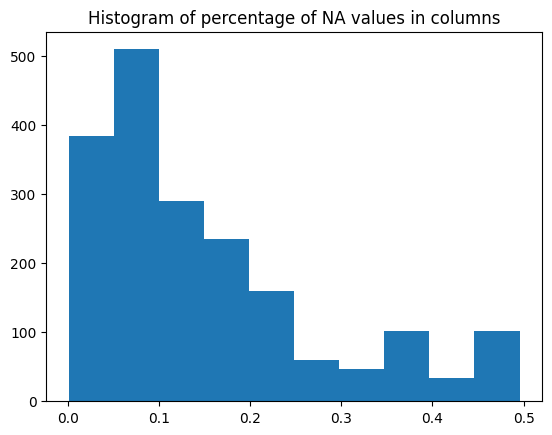

In [128]:
plt.hist(calculate_missing_percentage(clean_df) / 100)
plt.title("Histogram of percentage of NA values in columns")

Step1 Results: Data went from (1209, 6553) --> (1021, 2118)

# Step 2: Feature Engineering.
Finding relevant columns in DISTGRAD and DISTPROF and placing them into buckets

In [129]:
distgrad_clean = drop_columns(distgrad)
distprof_clean = drop_columns(distprof)

Original Dataset Shape: (1209, 950)
Dropped Dataset Shape: (1209, 277)
Original Dataset Shape: (1209, 426)
Dropped Dataset Shape: (1209, 416)


Bucketing DISTGRAD columns into sub-buckets 

In [130]:
district_identifiers = [
    "DISTRICT_id", "DISTRICT", "DISTNAME", "COUNTY", "CNTYNAME",
    "REGION", "DFLCHART", "DFLALTED"
]

#Bucketing relevant columns within the DISTGRAD dataset
race_ethnicity = [
    "District 2022 Attendance: Two or More Races Days Membership",
    "District 2022 Attendance: African American Days Membership",
    "District 2022 Attendance: Hispanic Days Membership",
    "District 2022 Attendance: White Days Membership"
]

economic_special_needs = [
    "District 2022 Attendance: Econ Disadv Days Membership",  # Economically Disadvantaged
    "District 2022 Attendance: Special Ed Days Membership",   # Special Education
    "District 2022 Attendance: EB/EL Days Membership",        # English Learners
    "District 2022 Attendance: At Risk Days Membership"       # At-Risk Students
]

gender_distribution = [
    "District 2022 Attendance: Female Days Membership",
    "District 2022 Attendance: Male Days Membership"
]


Bucketing DISTPROF columns into sub-buckets

In [131]:
### STUDENT DEMOGRAPHICS ###
grade_level_student_membership = [
    "District 2023 Student Membership: EE Count",
    "District 2023 Student Membership: PK Count",
    "District 2023 Student Membership: KG Count",
    "District 2023 Student Membership: 01 Count",
    "District 2023 Student Membership: 02 Count",
    "District 2023 Student Membership: 03 Count",
    "District 2023 Student Membership: 04 Count",
    "District 2023 Student Membership: 05 Count",
    "District 2023 Student Membership: 06 Count",
    "District 2023 Student Membership: 07 Count",
    "District 2023 Student Membership: 08 Count",
    "District 2023 Student Membership: 09 Count",
    "District 2023 Student Membership: 10 Count",
    "District 2023 Student Membership: 11 Count",
    "District 2023 Student Membership: 12 Count",
    "District 2023 Student Membership: All Students Count"
]

race_ethnicity = [
    "District 2023 Student Membership: American Indian Count",
    "District 2023 Student Membership: Asian Count",
    "District 2023 Student Membership: Pacific Islander Count",
    "District 2023 Student Membership: Two or More Races Count",
    "District 2023 Student Membership: African American Count",
    "District 2023 Student Membership: Hispanic Count",
    "District 2023 Student Membership: White Count"
]

economic_special_needs = [
    "District 2023 Student Membership: Special Ed Count",
    "District 2023 Student Membership: Bilingual/ESL Count",
    "District 2023 Student Membership: Gifted & Talented Count",
    "District 2023 Student Membership: EB/EL Count",
    "District 2023 Student Membership: Econ Disadv Count",
    "District 2023 Student Membership: Non-Educationally Disadv Count",
    "District 2023 Student Membership: At Risk Count",
    "District 2023 Student Membership: Dyslexia Count",
    "District 2023 Student Membership: Section 504 Count",
    "District 2023 Student Membership: Title I Count",
    "District 2023 Student Membership: Homeless Count",
    "District 2023 Student Membership: Immigrant Count",
    "District 2023 Student Membership: Migrant Count",
    "District 2023 Student Membership: Military-Connected Count",
    "District 2023 Student Membership: Foster Care Count"
]

gender_distribution = [
    "District 2023 Student Membership: Male Count",
    "District 2023 Student Membership: Female Count"
]

### Class Size & Teacher-Student Ratio ###
class_size_student_counts = [
    "District 2023 Class Size: Sec Soc Stud- # Students",
    "District 2023 Class Size: Sec Sci     - # Students",
    "District 2023 Class Size: Sec Math    - # Students",
    "District 2023 Class Size: Sec For Lng - # Students",
    "District 2023 Class Size: Sec English - # Students",
    "District 2023 Class Size: Grade 6     - # Students",
    "District 2023 Class Size: Grade 5     - # Students",
    "District 2023 Class Size: Grade 4     - # Students",
    "District 2023 Class Size: Grade 3     - # Students",
    "District 2023 Class Size: Grade 2     - # Students",
    "District 2023 Class Size: Grade 1     - # Students",
    "District 2023 Class Size: Mixed Elem. - # Students",
    "District 2023 Class Size: Kindergarten- # Students"
]

### Class Size & Teacher-Student Ratio ### 
average_class_size = [
    "District 2023 Class Size: Sec Soc Stud- Avg Size",
    "District 2023 Class Size: Sec Sci     - Avg Size",
    "District 2023 Class Size: Sec Math    - Avg Size",
    "District 2023 Class Size: Sec For Lng - Avg Size",
    "District 2023 Class Size: Sec English - Avg Size",
    "District 2023 Class Size: Grade 6     - Avg Size",
    "District 2023 Class Size: Grade 5     - Avg Size",
    "District 2023 Class Size: Grade 4     - Avg Size",
    "District 2023 Class Size: Grade 3     - Avg Size",
    "District 2023 Class Size: Grade 2     - Avg Size",
    "District 2023 Class Size: Grade 1     - Avg Size",
    "District 2023 Class Size: Kindergarten- Avg Size"
]


staff_counts = [
    "District 2023 Staff: Teacher Total Full Time Equiv Count",
    "District 2023 Staff: Support Total Full Time Equiv Count",
    "District 2023 Staff: School Admin Total Full Time Equiv Count",
    "District 2023 Staff: Central Admin Total Full Time Equiv Count",
    "District 2023 Staff: Educ Aide Total Full Time Equiv Count",
    "District 2023 Staff: Auxiliary Total Full Time Equiv Count",
    "District 2023 Staff: All Staff Total Full Time Equiv Count"
]


### Staff Demographics ### 
staff_counts = [
    "District 2023 Staff: Teacher Total Full Time Equiv Count",
    "District 2023 Staff: Support Total Full Time Equiv Count",
    "District 2023 Staff: School Admin Total Full Time Equiv Count",
    "District 2023 Staff: Central Admin Total Full Time Equiv Count",
    "District 2023 Staff: Educ Aide Total Full Time Equiv Count",
    "District 2023 Staff: Auxiliary Total Full Time Equiv Count",
    "District 2023 Staff: All Staff Total Full Time Equiv Count"
]

teacher_experience = [
    "District 2023 Staff: Teacher Beginning Full Time Equiv Count",
    "District 2023 Staff: Teacher 1-5 Years Full Time Equiv Count",
    "District 2023 Staff: Teacher 6-10 Years Full Time Equiv Count",
    "District 2023 Staff: Teacher 11-20 Years Full Time Equiv Count",
    "District 2023 Staff: Teacher 21-30 Years Full Time Equiv Count",
    "District 2023 Staff: Teacher > 30 Years Full Time Equiv Count"
]


staff_qualifications = [
    "District 2023 Staff: Teacher No Degree Full Time Equiv Count",
    "District 2023 Staff: Teacher BA Degree Full Time Equiv Count",
    "District 2023 Staff: Teacher MS Degree Full Time Equiv Count",
    "District 2023 Staff: Teacher PH Degree Full Time Equiv Count"
]

staff_race_ethnicity = [
    "District 2023 Staff: Teacher American Indian Full Time Equiv Count",
    "District 2023 Staff: Teacher Pacific Islander Full Time Equiv Count",
    "District 2023 Staff: Teacher Asian Full Time Equiv Count",
    "District 2023 Staff: Teacher African American Full Time Equiv Count",
    "District 2023 Staff: Teacher Hispanic Full Time Equiv Count",
    "District 2023 Staff: Teacher White Full Time Equiv Count",
    "District 2023 Staff: Teacher Two or more races Full Time Equiv Count"
]

staff_gender_distribution = [
    "District 2023 Staff: Teacher Male Full Time Equiv Count",
    "District 2023 Staff: Teacher Female Full Time Equiv Count"
]

Making overall big buckets

In [132]:
district_identifiers = [
    "DISTRICT_id", "DISTRICT", "DISTNAME", "COUNTY", "CNTYNAME",
    "REGION", "DFLCHART", "DFLALTED"
] + [
    "District",
    "District Number",
    "TEA District Type",
    "TEA Description",
    "NCES District Type",
    "NCES Description",
    "Charter School (Y/N)"
]



student_demographics = (
    grade_level_student_membership +
    race_ethnicity +
    economic_special_needs +
    gender_distribution + 
    race_ethnicity + 
    economic_special_needs + 
    gender_distribution
)

class_size_teacher_ratio = (
    class_size_student_counts +
    average_class_size
)

staff_demographics = (
    staff_counts +
    teacher_experience +
    staff_qualifications +
    staff_race_ethnicity +
    staff_gender_distribution
)


Exploring these buckets and the number of NAs

130

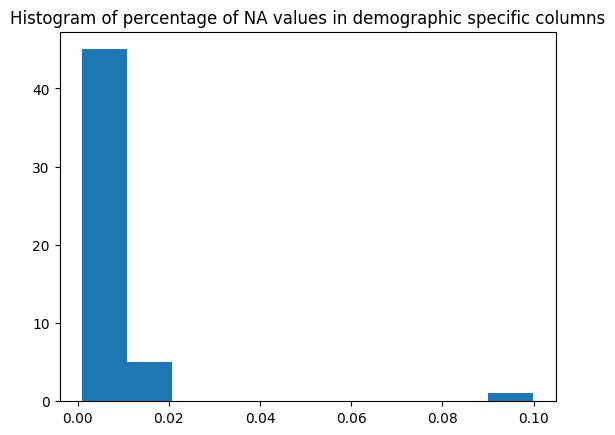

In [ ]:
demographic_data = clean_df[district_identifiers + student_demographics + class_size_teacher_ratio +staff_demographics]
demographic_data

plt.hist(calculate_missing_percentage(demographic_data) / 100)
plt.title("Histogram of percentage of NA values in demographic specific columns")
len(list(demographic_data.columns))

Exploring the non demographic data (Outcome oriented data) and looking at the number of NAs 

2046

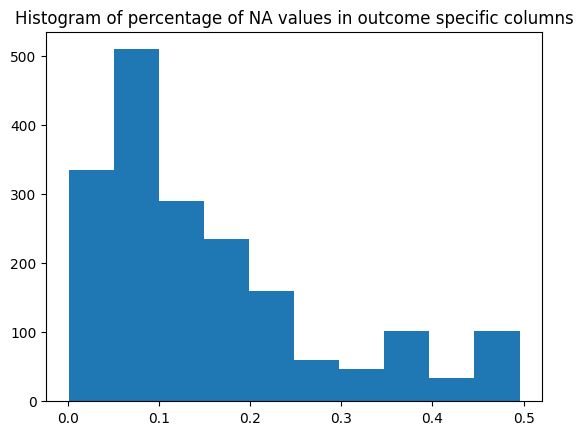

In [167]:
outcome_col = list(set(clean_df.columns) - set(student_demographics + class_size_teacher_ratio + staff_demographics))
outcome_df = clean_df[outcome_col]
outcome_df
plt.hist(calculate_missing_percentage(outcome_df) / 100)
plt.title("Histogram of percentage of NA values in outcome specific columns")
len(list(outcome_df.columns))

Key takaways, the demographic data contains very few columns with a lot of NAs! The outcome oriented data on the other hand varies slightly. Regardless, the data science portion (fitting a knn model) will occur on mostly complete data

# Step 3: Data Modeling: 


Helper function visualizing the number of NAs that were imputed in the dataset. Ideally we want this to be slim because we don't want our datascience model built from not true data. 

In [196]:
def visualize_missing_data(df, feature_columns, district_ids):
    """
    Visualizes missing data distribution for the queried district and its nearest neighbors.
    
    Parameters:
        df (pd.DataFrame): The full dataset.
        feature_columns (list): List of feature columns.
        district_ids (list): List of districts to analyze (queried + nearest neighbors).
    """
    # Filter dataset to only the relevant districts
    subset_df = df[df["DISTRICT_id"].isin(district_ids)]
    missing_rates = subset_df[feature_columns].isnull().mean() * 100  # Convert to percentage

    # Define new bins for clearer interpretation
    missing_bins = {
        "0% (No Imputation)": (missing_rates == 0).sum(),
        "1-5%": ((missing_rates > 0) & (missing_rates <= 5)).sum(),
        "6-10%": ((missing_rates > 5) & (missing_rates <= 10)).sum(),
        "11-20%": ((missing_rates > 10) & (missing_rates <= 20)).sum(),
        "21-50%": ((missing_rates > 20) & (missing_rates <= 50)).sum(),
        ">50% (Heavily Imputed)": (missing_rates > 50).sum(),
    }

    # Plot the stacked bar chart
    plt.figure(figsize=(8, 5))
    plt.bar(missing_bins.keys(), missing_bins.values(), color=["green", "lightgreen", "yellow", "orange", "red", "darkred"])
    plt.xlabel("Missing Data Percentage Ranges")
    plt.ylabel("Number of Features")
    plt.title("Feature Missing Data Distribution (Queried District & Nearest Neighbors)")
    plt.show()


Helper function visualizing how close neighbors are to selected value. 

In [197]:
def visualize_similarity(df, feature_columns, district_ids, metric="euclidean"):
    """
    Visualizes similarity between the queried district and its nearest neighbors.
    
    Parameters:
        df (pd.DataFrame): The full dataset.
        feature_columns (list): Feature columns used in KNN.
        district_ids (list): Queried district + nearest neighbors.
        metric (str): Distance metric for similarity ("euclidean" by default).
    """
    # Filter dataset to only the relevant districts
    subset_df = df[df["DISTRICT_id"].isin(district_ids)].set_index("DISTRICT_id")[feature_columns]
    
    # Normalize and impute missing data
    imputer = SimpleImputer(strategy="median")
    subset_df_imputed = pd.DataFrame(imputer.fit_transform(subset_df), columns=subset_df.columns, index=subset_df.index)

    scaler = StandardScaler()
    subset_df_scaled = pd.DataFrame(scaler.fit_transform(subset_df_imputed), columns=subset_df.columns, index=subset_df.index)

    # Compute pairwise distances
    knn_model = NearestNeighbors(metric=metric)
    knn_model.fit(subset_df_scaled)
    distances, _ = knn_model.kneighbors(subset_df_scaled)

    # === 1. HEATMAP: Pairwise Distance Matrix ===
    plt.figure(figsize=(10, 6))
    sns.heatmap(distances, annot=True, cmap="Blues", xticklabels=subset_df.index, yticklabels=subset_df.index)
    plt.title("Pairwise Distance Matrix (Lower = More Similar)")
    plt.xlabel("Nearest Neighbor")
    plt.ylabel("Queried District & Nearest Neighbors")
    plt.show()

    # === 2. MULTIDIMENSIONAL SCALING (MDS) PLOT ===
    mds = MDS(n_components=2, dissimilarity="euclidean", random_state=42)
    mds_coords = mds.fit_transform(subset_df_scaled)

    plt.figure(figsize=(8, 6))
    for i, district in enumerate(subset_df.index):
        plt.scatter(mds_coords[i, 0], mds_coords[i, 1], label=district)
        plt.text(mds_coords[i, 0], mds_coords[i, 1], str(district), fontsize=10, ha="right")

    plt.title("2D Similarity Projection (MDS)")
    plt.xlabel("MDS Component 1")
    plt.ylabel("MDS Component 2")
    plt.legend()
    plt.show()

    # === 3. DENDROGRAM: Hierarchical Clustering ===
    plt.figure(figsize=(10, 5))
    linkage_matrix = linkage(subset_df_scaled, method="ward")
    dendrogram(linkage_matrix, labels=subset_df.index, leaf_rotation=90, leaf_font_size=10)
    plt.title("Hierarchical Clustering of Districts")
    plt.xlabel("District")
    plt.ylabel("Dissimilarity")
    plt.show()

In [198]:
def find_nearest_districts(df, district_id, feature_buckets, n_neighbors=5, impute_strategy="median", visualize=True):
    """
    Finds the nearest neighboring districts using KNN and optionally visualizes similarity.
    """
    # Step 1: Filter dataset for selected features
    existing_columns = [col for col in feature_buckets if col in df.columns]
    
    # Select only available columns
    knn_df = df[["DISTRICT_id"] + existing_columns].copy()
    
    # Step 2: Handle missing values
    imputer = SimpleImputer(strategy=impute_strategy)
    knn_df[existing_columns] = imputer.fit_transform(knn_df[existing_columns])
    
    # Step 3: Normalize the feature set
    scaler = StandardScaler()
    knn_df[existing_columns] = scaler.fit_transform(knn_df[existing_columns])
    
    # Step 4: Fit KNN model (excluding DISTRICT_id)
    knn_model = NearestNeighbors(n_neighbors=n_neighbors, metric="euclidean")
    knn_model.fit(knn_df[existing_columns])
    
    # Step 5: Find the nearest neighbors for the specified district
    query_point = knn_df[knn_df["DISTRICT_id"] == district_id][existing_columns]
    if query_point.empty:
        raise ValueError(f"District ID {district_id} not found in dataset.")
    
    distances, indices = knn_model.kneighbors(query_point)
    
    # Step 6: Get the closest districts
    nearest_districts = knn_df.iloc[indices[0]]["DISTRICT_id"].tolist()
    
    # Step 7: Visualization (if enabled)
    if visualize:
        visualize_similarity(df, existing_columns, nearest_districts)

    return nearest_districts

Example Usage

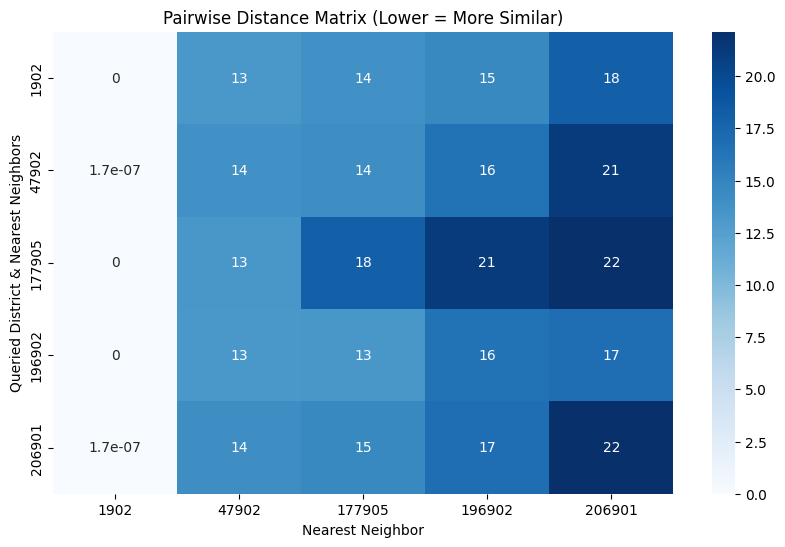

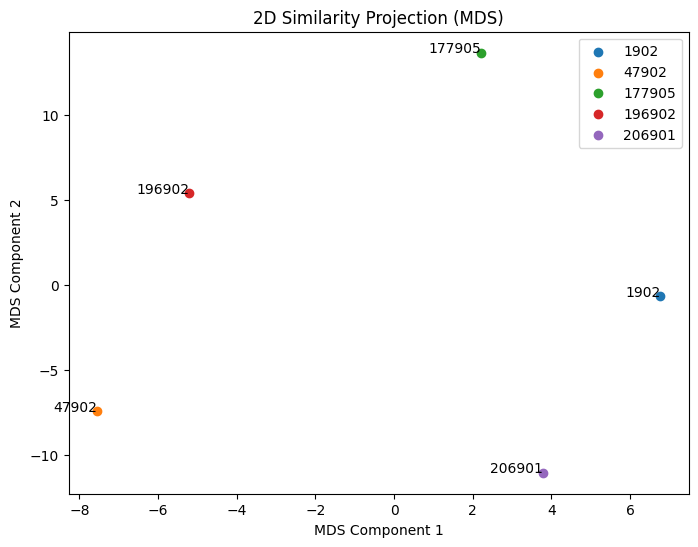

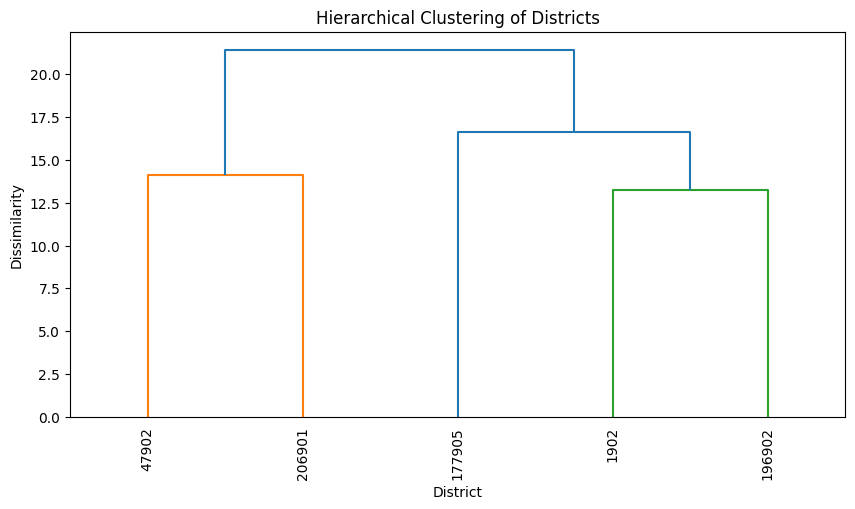

Top 5 closest districts: [1902, 196902, 206901, 177905, 47902]


In [199]:
selected_features = student_demographics + class_size_teacher_ratio + staff_demographics
closest_districts = find_nearest_districts(clean_df, 1902, selected_features)
print("Top 5 closest districts:", closest_districts)

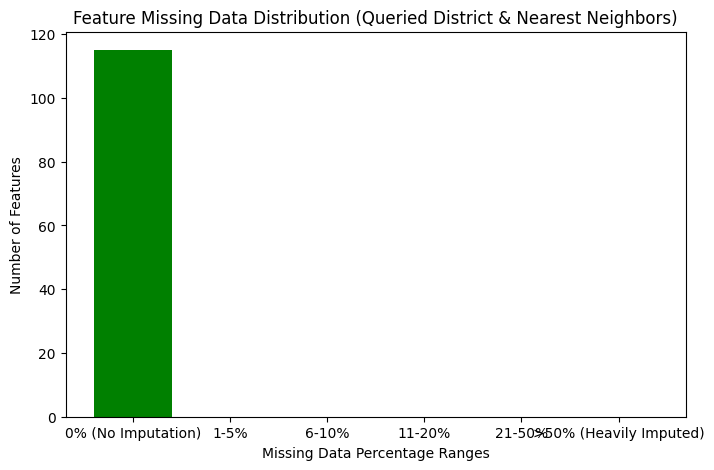

[39903, 119903, 230903, 70907, 18904]

In [179]:
find_nearest_districts(clean_df, 39903, selected_features)

In [194]:
#list(outcome_df)

outcome_df_nainfo = calculate_missing_percentage(outcome_df)
few_na_outcomes = outcome_df_nainfo[outcome_df_nainfo <=.2]
few_na_outcomes.index

Index(['District 2021 Attendance: Female Days Present',
       'District 2021 Attendance: Female Rate',
       'District 2023 Student Membership: 2022 Mobility Econ Disadv Percent',
       'District 2021 Attendance: All Students Days Present',
       'District 2022 Attendance: Male Days Present',
       'District 2021 Attendance: Female Days Membership',
       'District 2022 Attendance: Male Days Membership',
       'District 2022 Retention: Regular Ed 03 Rate',
       'District 2022 Attendance: Male Rate',
       '2022 district Chronic Absenteeism Econ Disadv Group: Rate',
       ...
       'District 2023 Staff: Principal Experience Average',
       'District 2023 Staff: Teacher 21-30 Years Full Time Equiv Percent',
       'District 2023 Staff: Teacher Bilingual Program Full Time Equiv Count',
       'District 2023 Staff: Counselor Total Part Time Equiv Count',
       'District 2023 Staff: Auxiliary Total Full Time Equiv Percent',
       'District 2023 Staff: Teacher Regular Program 

# Archive Code Used for Troubleshooting

In [ ]:
merged_df = distgrad_clean.merge(distprof_clean, how = 'left', on = 'DISTRICT_id')

all_columns = list(merged_df.columns)
missing_col1 = set(class_size_teacher_ratio) - set(all_columns)

print("Total Columns Missing from merged dataset")
print(len(list(missing_col1)))

print("Total Columns coming from class_size_student_counts list")
print(len(list(set(class_size_student_counts)- set(all_columns))))

print("Total Columns coming from average_class_size list")
print(len(list(set(average_class_size) - set(all_columns))))


print("How many missing columns exist in distgrad? ")
print(len(list(set(missing_col1) - set(list(distgrad_clean.columns)))))

print("How many missing columns exist in distprof?")
print(len(list(set(missing_col1) - set(list(distprof_clean.columns)))))

#Conclusion: These 18 columns that are not being recognized come from both distgrad and distprof, when merging there must be some funky business 
print(missing_col1)


print((list(set(average_class_size) - set(all_columns))))
search_term = 'District 2023 Class Size: Sec Math'

real_val = [col for col in merged_df.columns if search_term in col]
print(real_val)

In [ ]:
# Step 1: Select relevant feature buckets
selected_columns = student_demographics + class_size_teacher_ratio + staff_demographics

# Step 2: Filter dataset for selected features
#Get the intersection of selected_columns and existing columns in merged_df
existing_columns = [col for col in selected_columns if col in merged_df.columns]

# Select only available columns
knn_df = merged_df[["DISTRICT_id"] + existing_columns].copy()


# Step 3: Handle missing values (e.g., fill with median)
imputer = SimpleImputer(strategy="median")  # Change to 'mean' or 'most_frequent' if preferred
knn_df[selected_columns] = imputer.fit_transform(knn_df[selected_columns])

# Step 4: Normalize the feature set
scaler = StandardScaler()
knn_df[selected_columns] = scaler.fit_transform(knn_df[selected_columns])

# Step 5: Fit KNN model (excluding DISTRICT_id)
knn_model = NearestNeighbors(n_neighbors=5, metric="euclidean")  # Adjust neighbors as needed
knn_model.fit(knn_df[selected_columns])

# Step 6: Find the nearest neighbors for DISTRICT_id = 1902
query_point = knn_df[knn_df["DISTRICT_id"] == r"'001902"][selected_columns]
distances, indices = knn_model.kneighbors(query_point)

# Step 7: Get the closest districts
nearest_districts = clean_df.iloc[indices[0]]["DISTRICT_id"]

print("Top 5 closest districts to 1902:", nearest_districts.tolist())